# ANALYSIS OF METFORMIN CONTROL

This notebook contains an analysis of the effect of metformin on various tissues and organs as published in 


<img src="images/metformin-model-fits.png"
     alt="Markdown Monster icon" 
     width="800" height="1000"
     style="float: left; margin-right: 10px;" />

In [1]:
import controlSBML as ctl
import controlSBML.constants as cn

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
ctl.__version__

'1.0.11'

# Problem Statement and System Definition

1. Problem to solve.
2. Biological system (e.g., chemical pathway)
    1. inputs (e.g., species, kinetic constants)
    2. outputs (e.g., floating species, reaction rates)
1. Operating region (e.g., chemical concentrations in which system will operate)
1. Controllability analysis, that the inputs can change the outputs to achieve the control objectives within the operating region.

Metformin has proven effective at address type 2 diabetes. As such, there may be benefits if it is possible to maintain a constant dosage in physiological targets such as muscle. This is an exploratory study to investigate if the control of metformin in the blood (venus plasma) is sufficient to control metformin in muscle. This study considers a closed loop system in which: (a) metformin concentration is measured in muscle and (b) a controller can add metformin to the blood if its muscle concentration is low. We assume that there is no capability for removing metformin from the blood other than by physiological processes (e.g., intestinal absorption).

## Metformin Model

In [2]:
url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
METFORMIN_SYS = ctl.SBMLSystem(url, input_names=["mPlasmaVenous"], output_names=["mMuscle"],
                               is_fixed_input_species=False)

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.



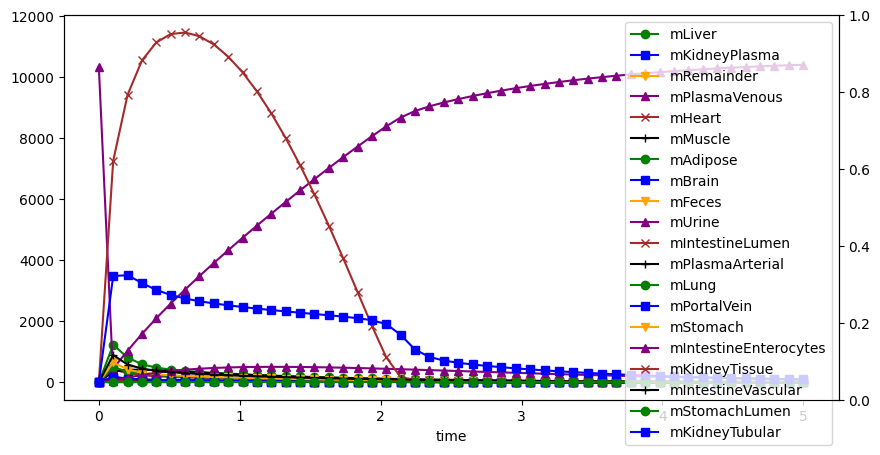

In [3]:
_ = METFORMIN_SYS.plotModel(figsize=(10,5))

In [4]:
print(METFORMIN_SYS.getValidInputs())

floating_species:	mLiver, mKidneyPlasma, mRemainder, mPlasmaVenous, mHeart, mMuscle, mAdipose, mBrain, mFeces, mUrine, mIntestineLumen, mPlasmaArterial, mLung, mPortalVein, mStomach, mIntestineEnterocytes, mKidneyTissue, mIntestineVascular, mStomachLumen, mKidneyTubular

parameter:	Metformin_Dose_in_Lumen_in_mg, Body_Weight, Metformin_Dose_in_Plasma_in_mg, Cardiac_Output, Ktp_Liver, Ktp_Brain, Ktp_Adipose, Ktp_Heart, Ktp_Kidney, Ktp_Muscle, Ktp_Remainder, Ktp_Lung, Ktp_Stomach, Ktp_IntestineVascular, Qgfr, Compartment_10, Compartment_9, Compartment_6, Compartment_7, Compartment_15, Compartment_0, Compartment_17, Compartment_2, Compartment_16, Compartment_19, Compartment_1, Compartment_12, Compartment_8, Compartment_11, Compartment_4, Compartment_13, Compartment_3, Compartment_18, Compartment_14, Compartment_5, ModelValue_1, ModelValue_3, ModelValue_0, ModelValue_37, ModelValue_34, ModelValue_47, ModelValue_36, ModelValue_35

assignment:	QAdipose, QBrain, QHeart, QKidney, QMuscle, QRema

In [5]:
print(METFORMIN_SYS.getValidOutputs())

floating_species:	mLiver, mKidneyPlasma, mRemainder, mPlasmaVenous, mHeart, mMuscle, mAdipose, mBrain, mFeces, mUrine, mIntestineLumen, mPlasmaArterial, mLung, mPortalVein, mStomach, mIntestineEnterocytes, mKidneyTissue, mIntestineVascular, mStomachLumen, mKidneyTubular

parameter:	Metformin_Dose_in_Lumen_in_mg, Body_Weight, Metformin_Dose_in_Plasma_in_mg, Cardiac_Output, Ktp_Liver, Ktp_Brain, Ktp_Adipose, Ktp_Heart, Ktp_Kidney, Ktp_Muscle, Ktp_Remainder, Ktp_Lung, Ktp_Stomach, Ktp_IntestineVascular, Qgfr, Compartment_10, Compartment_9, Compartment_6, Compartment_7, Compartment_15, Compartment_0, Compartment_17, Compartment_2, Compartment_16, Compartment_19, Compartment_1, Compartment_12, Compartment_8, Compartment_11, Compartment_4, Compartment_13, Compartment_3, Compartment_18, Compartment_14, Compartment_5, ModelValue_1, ModelValue_3, ModelValue_0, ModelValue_37, ModelValue_34, ModelValue_47, ModelValue_36, ModelValue_35

assignment:	QAdipose, QBrain, QHeart, QKidney, QMuscle, QRema

In [6]:
METFORMIN_SYS.printModel()

// Created by libAntimony v2.13.2
function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function Glomerular(S, Flow)
  S*Flow;
end

Glomerular is "Glomerular"

function Flow(Q, S)
  Q*S;
end

Flow is "Flow"

function Flow_from_organ(Q, S, Ktp)
  Q*S/Ktp;
end

Flow_from_organ is "Flow from organ"


model *Zake2021___PBPK_model_of_metformin_in_mice__single_dose_intavenous()

  // Compartments and Species:
  compartment IntestineLumen, Liver, KidneyPlasma, Remainder, PlasmaVenous;
  compartment Urine, Feces, Heart, Muscle, Brain, Adipose, PlasmaArterial;
  compartment Lung, PortalVein, Stomach, IntestineEnterocytes, KidneyTissue;
  compartment IntestineVascular, StomachLumen, KidneyTubular;
  substanceOnly species mLiver in Liver, mKidneyPlasma in KidneyPlasma, mRemainder in Remainder;
  substanceOnly species mPlasmaVenous in PlasmaVenous, mHeart in Heart, mMuscl

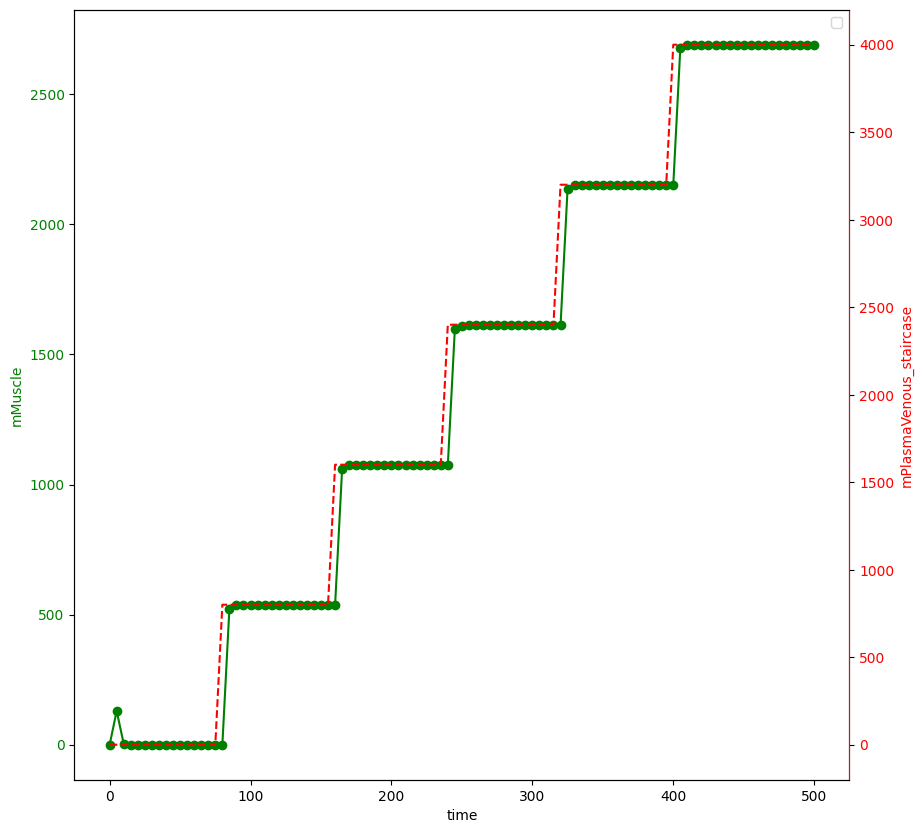

In [7]:
METFORMIN_STAIRCASE = ctl.Staircase(initial_value=0, final_value=4000, num_step=5)
METFORMIN_BUILDER = ctl.SISOTransferFunctionBuilder(METFORMIN_SYS)
response_ts = METFORMIN_BUILDER.makeStaircaseResponse(staircase=METFORMIN_STAIRCASE, end_time=500)
METFORMIN_BUILDER.plotStaircaseResponse(response_ts)

The system can achieve Metformin levels up to 2500 units for the range of Metformin in blood plasma. The control objective is to minimize settling time subject to the constraint that there is no overshoot. These maximizes the speed of adaptation without excessive variation in Metformin levels.

# System Identification

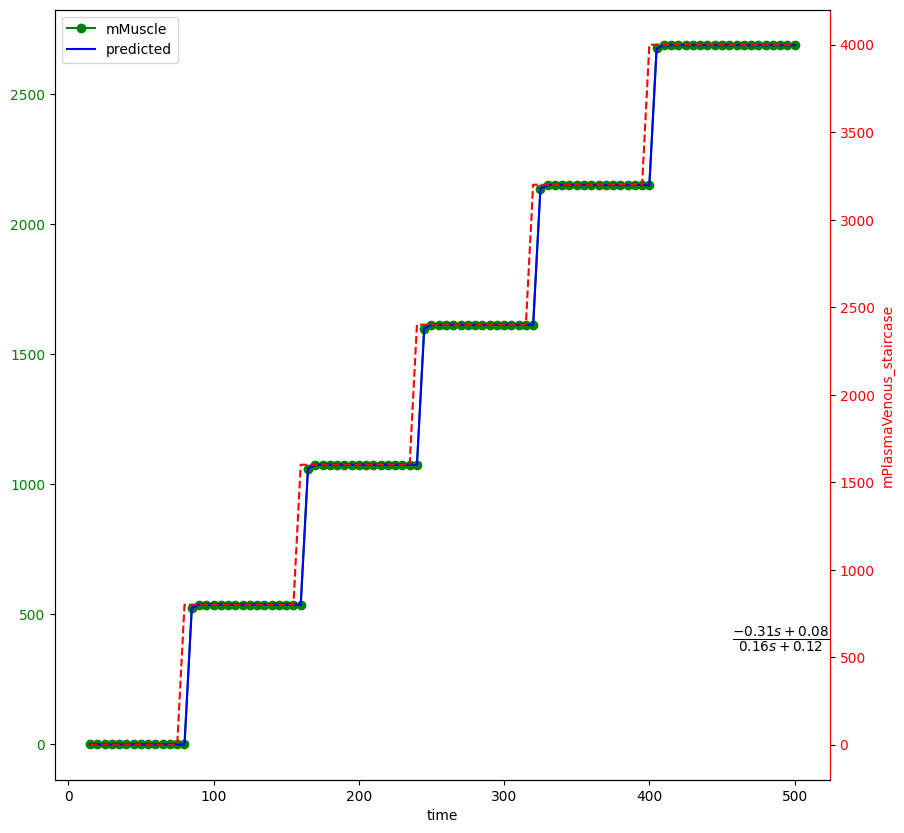

In [8]:
fitter_result = METFORMIN_BUILDER.fitTransferFunction(num_numerator=2, num_denominator=3, 
                                                      staircase=METFORMIN_STAIRCASE, 
                                                      fit_start_time=10, start_time=0, end_time=500)
METFORMIN_BUILDER.plotFitTransferFunction(fitter_result)

In [9]:
fitter_result.rms_residuals

1.3708173863594213

# Testbed Construction

Create an Antimony simulations that allow for easily changing the control design.

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

**Issue**
1. Have a high initial value of mPlasmaVenous

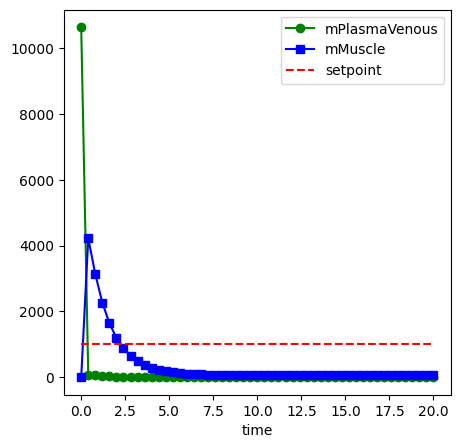

In [14]:
setpoint = 1e3
ts, builder = METFORMIN_SYS.simulateSISOClosedLoop(kp=0.1, end_time=20, is_steady_state=True, setpoint=setpoint,
                                                  initial_input_value=None)
METFORMIN_SYS.plotSISOClosedLoop(ts, setpoint, figsize=(5,5))

Objective: Minimize settling time subject to constraint that mPlasmaVenous and all floating species >= 0.
1. Approximate solution using transfer functions
2. Refine using simulations.

# Closed Loop Design and Evaluation